<a href="https://colab.research.google.com/github/jumafernandez/UNLP/blob/master/TFI/LSA_LDA_TFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cargo las librerías



In [151]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


### Levanto los datos

In [152]:
# Descargo el archivo con las consultas que está en Github
!wget https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv

# Leo el archivo en un dataframe
import pandas as pd

df = pd.read_csv('Correos_Seleccionados_y_Etiquetados.csv', delimiter="|")
df.info()

# Vemos la cantidad de Instancias por clase
df.Clase.value_counts()

# Transformamos todas las Clases minoritarias (Puedo ir variando la cantidad de clases que derivo a la Clase "Otras Consultas")
cantidad_clases=3
clases = df.Clase.value_counts()
clases_minoritarias = clases.iloc[cantidad_clases:].keys().to_list()
df.Clase[df['Clase'].isin(clases_minoritarias)] = "Otras Consultas"

df.Clase.value_counts()

--2020-12-08 09:27:20--  https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448336 (438K) [text/plain]
Saving to: ‘Correos_Seleccionados_y_Etiquetados.csv.4’

Correos_Seleccionad 100%[===================>] 437.83K  --.-KB/s    in 0.03s   

2020-12-08 09:27:20 (14.6 MB/s) - ‘Correos_Seleccionados_y_Etiquetados.csv.4’ saved [448336/448336]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              1000 non-null   object
 1   Hora               1000 non-null   object
 2   Apellido y Nombre  1000 non

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Otras Consultas             399
Boleto Universitario        240
Ingreso a la Universidad    232
Requisitos de Ingreso       129
Name: Clase, dtype: int64

In [153]:
# Miro las primeras dos consultas
df.head(2)

,Fecha,Hora,Apellido y Nombre,Legajo,Documento,Carrera,Teléfono,E-mail,Consulta,Respuesta,Clase
0,08-05-2019,10:49:26,florencia roland,169336,33829069,licenciatura en enfermeria(52),1121550750,rolandflorencia@gmail.com,"hola quiero anotarme a las materias ,para el s...",te falta presentar alguna de las vacunas sal...,Otras Consultas
1,08-08-2017,12:29:59,lourdes vanesa gómez,150786,33220121,licenciatura en enfermeria(52),1131066251,vane_male@outlook.com,hola buenos días! quería saber cuando voy a po...,lo que falta es que la coordinación autorice l...,Otras Consultas


In [154]:
# Chequeo dimensionalidad
df.shape

(1000, 11)

In [155]:
# Verifico las columnas del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              1000 non-null   object
 1   Hora               1000 non-null   object
 2   Apellido y Nombre  1000 non-null   object
 3   Legajo             691 non-null    object
 4   Documento          1000 non-null   int64 
 5   Carrera            1000 non-null   object
 6   Teléfono           851 non-null    object
 7   E-mail             1000 non-null   object
 8   Consulta           1000 non-null   object
 9   Respuesta          1000 non-null   object
 10  Clase              1000 non-null   object
dtypes: int64(1), object(10)
memory usage: 86.1+ KB


### Realizo el preprocesamiento de los datos

In [156]:
# Defino una lista negra de palabras adicionales a las stop_words para borrar
black_list = ['más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a', 'compa', 'acompa', 'off', 'and', 'grecia', 'the','it', 'to',
              'd',  'et',  'dame',  'il',  'dans', 'that',  'as',   'for',  'it',  'elections',  'would',  'this',  'with', 'york', 'obama', 'chavez', 'gadafi']

In [157]:
# Creo una función que limpia el texto en español, borrando caracteres no alfanuméricos, removiendo duplicados, dígitos, etc, etc
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'ee.uu', 'eeuu', word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word)
  word = re.sub(r'ja{2,}', 'ja', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())

  bigram_list = bigram[list_word_clean]
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

Se crea la función para seleccionar **solo sustantivos** para nuestros datos, de esta manera estamos eliminando adverbio, adjetivos, verbos, etc. Esto está hecho con spacy

In [158]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

Transformamos el dataframe a una lista como solicita gensim

In [159]:
len(df.Consulta.to_list())

1000

Luego buscamos bigrama en nuestros datos, es decir, un par de palabras que juntas tienen más significado para nuestro modelo.

In [160]:
%%time
bigram = gensim.models.Phrases(df.Consulta.to_list()) 

CPU times: user 222 ms, sys: 2.07 ms, total: 224 ms
Wall time: 222 ms


Verificamos el output

In [161]:
bigram[df.Consulta.to_list()[0].split()]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['hola',
 'quiero',
 'anotarme',
 'a',
 'las',
 'materias',
 ',para',
 'el',
 'segundo',
 'cuatri',
 ',pero',
 'no',
 'puedo',
 ',dice',
 'que',
 'no',
 'estoy',
 'en',
 'condiciones,me',
 'podrian',
 'decir',
 'que',
 'tengo',
 'que',
 'hacer,muchas',
 'gracias']

In [162]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [163]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

additional_stopwords=set(black_list)

stopwords = stop.union(additional_stopwords)

Usamos spacy para lematizar las palabras

In [164]:
!python -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [165]:
import spacy
import spacy.cli
spacy.cli.download("es_core_news_md")
import es_core_news_md
nlp = es_core_news_md.load()

#nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/es_core_news_md/es_core_news_md-2.1.0')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


Probamos la función para la limpieza de texto

In [166]:
df.Consulta[0]

'hola quiero anotarme a las materias ,para el segundo cuatri ,pero no puedo ,dice que no estoy en condiciones,me podrian decir que tengo que hacer,muchas gracias  '

In [167]:
cleaner(df.Consulta[0])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['materias', 'cuatri', 'hacermuchas', 'gracias']

##### Let's clean all the text

In [168]:
df['Consulta_bp'] = df['Consulta']

In [169]:
%%time
df['Consulta'] = df['Consulta'].apply(cleaner)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 8.94 s, sys: 2.43 ms, total: 8.94 s
Wall time: 8.94 s


Ahora necesitamos construir el **corpus** y el **diccionario** que gensim necesita para funcionar, para hacer eso necesitamos pasar la lista a una lista de tokens:

In [170]:
dictionary = Dictionary(df['Consulta'].to_list())
dictionary.compactify()

# Filtro extremos
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df['Consulta'].to_list()]

corpus

[[(0, 1), (1, 1)],
 [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1)],
 [(0, 1), (4, 1), (10, 1), (11, 1), (12, 1)],
 [(0, 1), (13, 1)],
 [(14, 1), (15, 3), (16, 1)],
 [(0, 2), (4, 2), (9, 1), (17, 1)],
 [(18, 1)],
 [(14, 2), (19, 1), (20, 1), (21, 1)],
 [(0, 1), (7, 1), (22, 1), (23, 1)],
 [(0, 1),
  (1, 1),
  (15, 1),
  (16, 1),
  (18, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)],
 [(0, 1), (14, 1), (24, 1), (28, 1), (29, 1), (30, 1)],
 [(0, 1), (16, 1), (24, 1)],
 [(31, 1), (32, 1), (33, 1)],
 [(0, 1), (20, 1), (34, 1), (35, 1), (36, 1), (37, 1)],
 [(11, 1), (34, 1)],
 [(38, 1), (39, 1), (40, 1)],
 [(0, 1), (32, 1), (39, 1), (41, 1), (42, 1), (43, 1)],
 [(0, 1), (44, 1), (45, 1), (46, 1)],
 [(47, 1)],
 [(0, 1), (34, 1), (48, 1), (49, 1)],
 [],
 [(1, 1), (10, 1), (18, 1), (50, 1)],
 [(1, 1)],
 [(20, 1)],
 [(12, 1), (51, 1)],
 [(0, 1), (18, 1), (52, 1), (53, 1), (54, 1)],
 [(14, 1), (15, 1), (55, 1), (56, 1)],
 [(0, 1), (37, 1), (38, 1), (57, 1), (58, 1), 

# Now let's do the modeling part

We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent
semantic analysis (LSA), Hierarchical Dirichlet Process
(HDP),in order to evaluate topic models we will be using **topic coherence**, which is a measure of how
interpretable topics are for human beings.

In [171]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "lsi":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")
    



In [172]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [173]:
lsimodel = LsiModel(corpus=corpus, num_topics=11, id2word=dictionary)

In [174]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
gracias boleto beneficio tardes materias respuesta carrera clave dia saludos 

Topic 1:
beneficio boleto materias gracias clave carrera tarjeta requisitos cuatrimestre porcentaje 

Topic 2:
materias gracias beneficio clave porcentaje certificado requisitos cuatrimestre boleto correo 

Topic 3:
boleto beneficio tardes clave carrera gracias correo materias tarjeta favor 

Topic 4:
clave carrera tardes materias boleto saludos perfil gracias correo contador 

Topic 5:
carrera tardes clave boleto gracias dia contador perfil cuatrimestre legajo 

Topic 6:
tardes boleto gracias beneficio requisitos inscripcion correo clave saludos carrera 

Topic 7:
requisitos sistema tardes inscripcion dia estudiante perfil boleto materias clave 

Topic 8:
titulo respuesta solicitud saludos dia requisitos correo gracias legajo problema 

Topic 9:
correo paso clave titulo inscripcion saludos tardes legajo solicitud perfil 

Topic 10:
dia respuesta datos perfil favor requisitos solicitud llego mes tit

It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

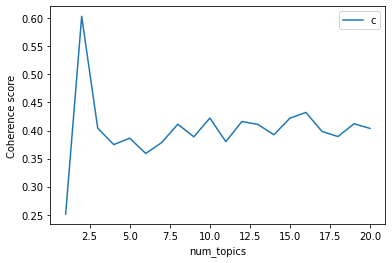

CPU times: user 11.4 s, sys: 2.68 s, total: 14.1 s
Wall time: 12.4 s


In [175]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df['Consulta'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [176]:
display_topics(lmlist_lsi[2])

Topic 0:
gracias boleto beneficio tardes materias respuesta carrera clave dia saludos 

Topic 1:
beneficio boleto materias gracias clave carrera tarjeta requisitos cuatrimestre porcentaje 

Topic 2:
materias gracias beneficio clave porcentaje certificado requisitos cuatrimestre boleto correo 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [177]:
ldamodel = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [178]:

display_topics(ldamodel)

Topic 0:
gracias materias porcentaje tardes certificado boleto correo clave pasos inscripcion 

Topic 1:
tardes gracias beneficio legajo fecha dia materias cuatrimestre semana pagina 

Topic 2:
gracias perfil tardes materias clave respuesta dia requisitos problemas saludos 

Topic 3:
gracias requisitos cuenta clave boleto favor problema estudiante datos acceso 

Topic 4:
gracias carrera tardes beneficio contador cambio formulario boleto mes titulo 

Topic 5:
gracias carrera sistema materias horarios taller boleto curso requisitos dia 

Topic 6:
gracias respuesta alumno boleto horarios clave beneficio problema requisitos dia 

Topic 7:
requisitos boleto perfil carrera dia gracias inscripcion sistema datos consulta 

Topic 8:
gracias boleto tardes beneficio consulta error solicitud legajo llego universidad 

Topic 9:
gracias materias cuatrimestre situacion respuesta beneficio dia boleto cuenta tardes 

Topic 10:
boleto gracias inscripcion materias beneficio papeles saludos formulario dia

Find out the optimal number of topics for the LDA model based on the coherence metric:

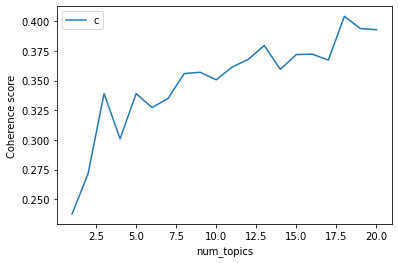

CPU times: user 22 s, sys: 1.32 s, total: 23.3 s
Wall time: 24 s


In [179]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df['Consulta'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [180]:

ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [181]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df['Consulta'].to_list(), dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=df['Consulta'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


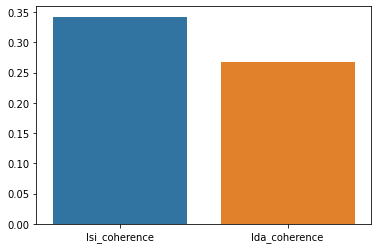

In [182]:
import seaborn as sns

coherences = [lsi_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence', 'lda_coherence']
sns.barplot(x, coherences)


We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [183]:
display_topics(ldamodel)

Topic 0:
gracias correo problema porcentaje boleto materias requisitos sistema certificado tardes 

Topic 1:
materias gracias clave beneficio respuesta cuatrimestre legajo boleto noches requisitos 

Topic 2:
gracias dia materias boleto respuesta titulo tarjeta beneficio situacion tiempo 

Topic 3:
gracias beneficio clave boleto correo solicitud dia certificado datos saludos 

Topic 4:
boleto gracias materias mensaje tardes requisitos consulta formulario solicitud inscripcion 

Topic 5:
boleto carrera gracias correo materias beneficio cuatrimestre pagina pasos clave 

Topic 6:
gracias clave carrera cuatrimestre boleto materias respuesta beneficio contador dia 

Topic 7:
gracias boleto carrera beneficio marzo requisitos consulta perfil legajo sistema 

Topic 8:
gracias tardes beneficio boleto saludos materias carrera datos consulta motivo 

Topic 9:
legajo gracias inscripcion correo nota requisitos tardes boleto dia fecha 

Topic 10:
materias requisitos gracias boleto perfil saludos dia 

It looks like the topics are:
* Topic 0: is about trials (justice)
* Topic 1: is like nature studies
* Topic 2: is about violence (against women maybe?)
* Topic 3: protest and disturb (like venezuelan case)
* Topic 4: is about life and family
* Topic 5: sea disasters
* Topic 6: elections
* Topic 7: is about terrorism
* Topic 8: is about economic crisis
* Topic 9: is like seism studies
* Topic 10: is about peacy treaty
* Topic 11: airport and security


Let´s check the keyword when we selecting another number of topics (14)

In [184]:
ldamodel_16 =lmlist[16]

In [185]:
display_topics(ldamodel_16)

Topic 0:
gracias dia materias tardes horarios solicitud saludos clave carrera beneficio 

Topic 1:
gracias clave tardes solicitud boleto email materias acceso contador alumno 

Topic 2:
gracias tardes correo titulo dia saludos solicitud respuesta horarios sistema 

Topic 3:
gracias boleto dia respuesta clave tarjeta correo situacion beneficio tardes 

Topic 4:
gracias boleto carrera curso problema cuatrimestre materias tardes materia respuesta 

Topic 5:
gracias materias carrera porcentaje beneficio tardes clave saludos certificado boleto 

Topic 6:
boleto gracias taller quot carrera comercio sistema titulo nombre tardes 

Topic 7:
gracias tardes clave consulta cuatrimestre horarios requisitos legajo saludos tiempo 

Topic 8:
gracias boleto titulo certificado alumno saludos perfil intento sede fecha 

Topic 9:
gracias beneficio boleto mes requisitos materias fecha saludos momento dia 

Topic 10:
gracias clave correo tardes respuesta materias motivo perfil datos requisitos 

Topic 11:
b

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [186]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df['Consulta'].to_list())

In [187]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6944,"materias, requisitos, gracias, boleto, perfil,...","[materias, cuatri, hacermuchas, gracias]"
1,1,10.0,0.5940,"materias, requisitos, gracias, boleto, perfil,...","[materias, prorroga, semana, respuesta, molest..."
2,2,11.0,0.7708,"carrera, gracias, requisitos, materias, horari...","[consulta, situacion, notas]"
3,3,6.0,0.8472,"gracias, clave, carrera, cuatrimestre, boleto,...","[noches, final, saque, respuesta, favor, gracias]"
4,4,8.0,0.6944,"gracias, tardes, beneficio, boleto, saludos, m...","[promedio, gracias]"
5,5,6.0,0.8472,"gracias, clave, carrera, cuatrimestre, boleto,...","[carrera, contador, simultaneidad, asiganturas..."
6,6,2.0,0.8690,"gracias, dia, materias, boleto, respuesta, tit...","[principio, gracias, respuesta, situacion, cal..."
7,7,6.0,0.5417,"gracias, clave, carrera, cuatrimestre, boleto,...","[transcurso, cuatrimestre, medios]"
8,8,5.0,0.8472,"boleto, carrera, gracias, correo, materias, be...","[carrera, taller, regularidad, carrera, sistema]"
9,9,6.0,0.5610,"gracias, clave, carrera, cuatrimestre, boleto,...","[consulta, nota, calificacion, gracias]"


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [188]:
label_dicc = {0:'trials', 1:'nature', 2:'violence', 3: 'protest', 4:'life_family', 5:'sea_disasters', 6:'elections', 
              7:'terrorism', 8:'economic_crisis', 9: 'seism', 10:'peacy_treaty', 11:'airport_security'}

In [189]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [190]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,peacy_treaty,0.6944,"materias, requisitos, gracias, boleto, perfil,...","[materias, cuatri, hacermuchas, gracias]"
1,1,peacy_treaty,0.5940,"materias, requisitos, gracias, boleto, perfil,...","[materias, prorroga, semana, respuesta, molest..."
2,2,airport_security,0.7708,"carrera, gracias, requisitos, materias, horari...","[consulta, situacion, notas]"
3,3,elections,0.8472,"gracias, clave, carrera, cuatrimestre, boleto,...","[noches, final, saque, respuesta, favor, gracias]"
4,4,economic_crisis,0.6944,"gracias, tardes, beneficio, boleto, saludos, m...","[promedio, gracias]"
5,5,elections,0.8472,"gracias, clave, carrera, cuatrimestre, boleto,...","[carrera, contador, simultaneidad, asiganturas..."
6,6,violence,0.8690,"gracias, dia, materias, boleto, respuesta, tit...","[principio, gracias, respuesta, situacion, cal..."
7,7,elections,0.5417,"gracias, clave, carrera, cuatrimestre, boleto,...","[transcurso, cuatrimestre, medios]"
8,8,sea_disasters,0.8472,"boleto, carrera, gracias, correo, materias, be...","[carrera, taller, regularidad, carrera, sistema]"
9,9,elections,0.5610,"gracias, clave, carrera, cuatrimestre, boleto,...","[consulta, nota, calificacion, gracias]"


In [191]:
df['labels'] = df_dominant_topic['Dominant_Topic']


Let's examine some text and its topics

In [192]:
df[['Consulta', 'labels']].head(10)

,Consulta,labels
0,"[materias, cuatri, hacermuchas, gracias]",peacy_treaty
1,"[materias, prorroga, semana, respuesta, molest...",peacy_treaty
2,"[consulta, situacion, notas]",airport_security
3,"[noches, final, saque, respuesta, favor, gracias]",elections
4,"[promedio, gracias]",economic_crisis
5,"[carrera, contador, simultaneidad, asiganturas...",elections
6,"[principio, gracias, respuesta, situacion, cal...",violence
7,"[transcurso, cuatrimestre, medios]",elections
8,"[carrera, taller, regularidad, carrera, sistema]",sea_disasters
9,"[consulta, nota, calificacion, gracias]",elections


In [193]:
df[ df['labels'] == 'family'].head().Consulta

Series([], Name: Consulta, dtype: object)

### let's see the distribution of topics


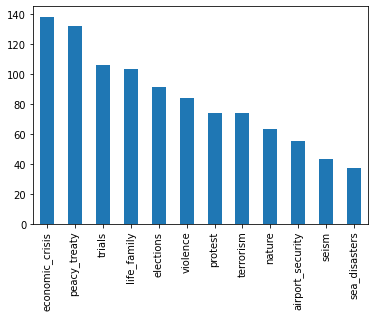

In [194]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [195]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 8.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=794e1b853e214c9c0e35c8a800520b4a230e1fec9015c7f3fee88c3360ae8667
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [196]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [197]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.003191  0.036625       1        1  16.003862
2      0.014751  0.002061       2        1  11.513666
10    -0.071967 -0.123507       3        1  10.430115
4      0.021956 -0.074190       4        1   9.777808
6      0.084524  0.037416       5        1   9.068777
7      0.061705  0.017587       6        1   8.116830
3      0.008930  0.105389       7        1   7.452842
1      0.031174 -0.038623       8        1   6.883112
0     -0.101928  0.064615       9        1   6.101486
11    -0.018662 -0.025366      10        1   5.706399
9     -0.120735  0.024563      11        1   5.031861
5      0.087062 -0.026570      12        1   3.913242, topic_info=            Term        Freq       Total Category  logprob  loglift
1       materias  175.000000  175.000000  Default  30.0000  30.0000
14       carrera   87.000000   87.000000  Default  29.0000  29.0000
86        correo   64.000000   64.000000  Default  28.0000  28.0000
37        tardes  120.000000  120.000000  Default  27.0000  27.0000
66         clave   91.000000   91.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
183        fecha    1.374834   21.539652  Topic12  -4.7206   0.4892
21        taller    1.374834   20.546132  Topic12  -4.7206   0.5365
46   universidad    1.374828   18.130294  Topic12  -4.7206   0.6615
47        alumno    1.374824   20.659370  Topic12  -4.7206   0.5310
15      contador    1.374819   15.101844  Topic12  -4.7206   0.8443

[686 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
251       1  0.155598   abril
251       3  0.155598   abril
251       6  0.622390   abril
51        1  0.131392  acceso
51        2  0.065696  acceso
...     ...       ...     ...
135       2  0.142777     web
135       7  0.071388     web
135       8  0.071388     web
135       9  0.071388     web
135      10  0.142777     web

[1293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 11, 5, 7, 8, 4, 2, 1, 12, 10, 6])

https://www.tutorialspoint.com/gensim/gensim_creating_lsi_and_hdp_topic_model.htm

https://github.com/ArmandDS/topic_modeling/blob/master/topic_modeling_spanish.ipynb